<a href="https://colab.research.google.com/github/mpolitano/redesNueronales/blob/master/Final2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/mnist')

Mounted at /mnist


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
from torch import nn
import pandas as pd
import torchvision.transforms as transforms
import os


 conjunto de datos de entrenamiento
 

In [4]:
n_epochs = 15
input_shape = 28*28

batch_size = 1000

random_seed = 1
torch.manual_seed(random_seed)

La squeeze elimina las capaz dummy. Como es blanco y negro, no necesitamos esta capa. Usamos una red fully conecty lineal.

Para el programa una imagen es en 3D pero no sotros queremos en 2D



imshow me permite graficar un array con forma de imagen
El dataset esta guardado como una lista de dos valores. El 0 es la imagen, el elemento 1 es la imagen

 conjunto de datos de test

In [5]:
## Transforms images to a PyTorch Tensor
transform = transforms.Compose([transforms.ToTensor()])

    # load the dataset
train_dataset = datasets.MNIST(
    root='./data', train=True,
    download=True, transform=transform
)

test_dataset = datasets.MNIST(
    root='./data', train=False,
    download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, 
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



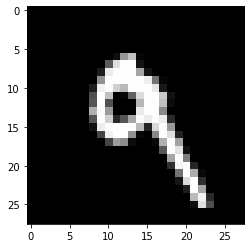

In [6]:
plt.imshow(test_dataset[7][0].numpy().squeeze(), cmap='gray')

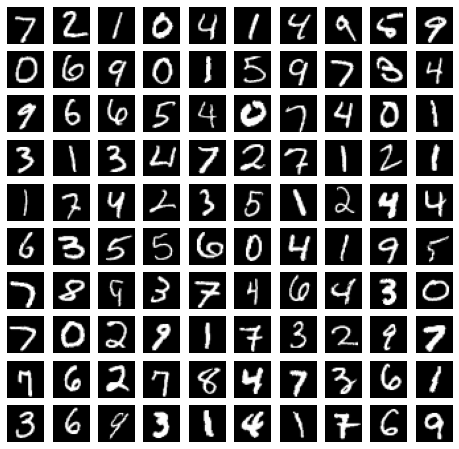

In [7]:
Nshowx = 10
Nshowy = 10
plt.figure(figsize=(8,8))
for i in range(1,Nshowx*Nshowy+1): 
    plt.subplot(Nshowx,Nshowy,i)
    plt.imshow(test_dataset.data[i-1], cmap='gray')
    plt.axis("off")
plt.savefig(os.path.join('ejemplos.pdf'), dpi=300)
plt.show()

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

print(train_dataset[10])

In [10]:
class Autoencoder(nn.Module):
  #Rellena de 0.
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( 
            # conv layer (depth from 1 --> 16), 3x3 kernels
            nn.Conv2d(1, 16,3, stride=1,padding=1), #28x28x1
            #WIthout Padding=#out:24x24x16    
            nn.ReLU(),
            #TEngo que tener cuidado de no perder info cuando reduzco. El padding me pone 0 en ese caso
            nn.MaxPool2d(2,stride=2,),     #out: #14x14x16                                 
            #Es importante que los filtros no sean tan grandes para perder info.
            #La info suele estar centrada en las imagenes
            nn.Conv2d(16, 4, 3, stride=1,padding=1),   #out: #14x14x16                 
            nn.ReLU(),     #
            nn.MaxPool2d(2,stride=2,),    #out: #7x7x4  
            # nn.Flatten(),
            # nn.Linear(64,5),
            # nn.ReLU(True),
            # nn.Linear(128, 5)

        )
        


        self.decoder = nn.Sequential(
            ## decoder layers ##
           ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
            # nn.Linear(5, 128),
            # nn.ReLU(True),
            # nn.Linear(5,64),
            # nn.ReLU(True),
            # nn.Unflatten(dim=1, unflattened_size=(4, 4, 4)),
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2),
            #sigmoid activation because we need the outputs to be between [0, 1]
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        
        x = self.decoder(x)
        return x

In [12]:
# network = Autoencoder().to(device)
# optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

model = Autoencoder()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)


In [13]:
from torchvision import models
from torchsummary import summary

summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4          [-1, 4, 112, 112]             580
              ReLU-5          [-1, 4, 112, 112]               0
         MaxPool2d-6            [-1, 4, 56, 56]               0
   ConvTranspose2d-7         [-1, 16, 112, 112]             272
              ReLU-8         [-1, 16, 112, 112]               0
   ConvTranspose2d-9          [-1, 1, 224, 224]              65
          Sigmoid-10          [-1, 1, 224, 224]               0
Total params: 1,077
Trainable params: 1,077
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 18.47
Params size (MB): 0.00
Estimated Tota

In [14]:
from torchvision import models
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cpu


In [16]:
# Mean Squared Error Loss
criterion = nn.MSELoss()

In [ ]:
for batch, (X, y) in enumerate(train_loader):
  print(batch)

In [21]:
train_losses = []
train_loss_values = []
test_loss_values = []

train_counter = []
test_losses = []
log_interval = 10

test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]


 

# **Nueva train **

In [19]:
def train_loop(dataloader):
  loss = 0
  #TRAIN
  for batch, (batch_features,_) in enumerate(dataloader):
      # load it to the active device
      batch_features = batch_features.to(device)
      
      # compute reconstructions
      outputs = model(batch_features)

      # compute training reconstruction loss
      train_loss = criterion(outputs, batch_features)

      #BACKPROPAGATION
      # reset the gradients back to zero
      # PyTorch accumulates gradients on subsequent backward passes
      optimizer.zero_grad()
        
      # compute accumulated gradients
      train_loss.backward()
      
      # perform parameter update based on current gradients
      optimizer.step()
      
      # add the mini-batch training loss to epoch loss
      loss += train_loss.item()
      
      # if batch % 100 == 0:
      #     loss, current = train_loss.item(), batch * len(batch_features)
      #     print(f"loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")

  # compute the epoch training loss
  avg_train_loss = loss / len(dataloader)

  train_loss_values.append(avg_train_loss)
  print("train loss = {:.6f} ".format(avg_train_loss))

In [20]:
#TEST
def test_loop(dataloader,):
  num_batches = len(dataloader)
  size = len(dataloader.dataset)

  with torch.no_grad():
      loss, correct = 0,0
      # for batch_features, _ in test_loader:
      for batch_features, _ in dataloader:

          # load it to the active device
          batch_features = batch_features.to(device)
          
          # compute reconstructions
          outputs = model(batch_features)
          
          # compute testing reconstruction loss
          test_loss = criterion(outputs, batch_features)
                      
          # add the mini-batch testing loss to epoch loss
          loss += test_loss.item()

          # add the mini-batch testing loss to epoch loss
          correct += (outputs.argmax(1) == batch_features).type(torch.float).sum().item()

  # compute the epoch testing loss
  avg_test_loss = loss / len(dataloader)

  test_loss_values.append(avg_test_loss)
  loss /= num_batches
  correct /= size
  # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  print("test loss = {:.6f}, ".format(avg_test_loss))


In [33]:
print(len(train_loader))

60


Nueva test


In [22]:
size = len(train_loader.dataset)

for epoch in range(n_epochs):
  #TRAIN
  train_loop(train_loader)
  #TEST
  test_loop(test_loader)
  # avg_train_loss = loss / len(train_loader)

  # train_loss_values_old.append(avg_train_loss)
  # display the epoch training loss
  print("epoch : {}/{}, train loss = {:.6f}, test loss = {:.6f}, ".format(
      epoch + 1, n_epochs, 0, 0)
  )







train loss = 0.172181 
test loss = 0.123278, 
epoch : 1/15, train loss = 0.000000, test loss = 0.000000, 
train loss = 0.079179 
test loss = 0.057799, 
epoch : 2/15, train loss = 0.000000, test loss = 0.000000, 
train loss = 0.053620 
test loss = 0.050742, 
epoch : 3/15, train loss = 0.000000, test loss = 0.000000, 
train loss = 0.045276 
test loss = 0.038897, 
epoch : 4/15, train loss = 0.000000, test loss = 0.000000, 
train loss = 0.032628 
test loss = 0.028325, 
epoch : 5/15, train loss = 0.000000, test loss = 0.000000, 
train loss = 0.025913 
test loss = 0.024100, 
epoch : 6/15, train loss = 0.000000, test loss = 0.000000, 
train loss = 0.022497 
test loss = 0.021126, 
epoch : 7/15, train loss = 0.000000, test loss = 0.000000, 
train loss = 0.020016 
test loss = 0.018921, 
epoch : 8/15, train loss = 0.000000, test loss = 0.000000, 
train loss = 0.018051 
test loss = 0.017127, 
epoch : 9/15, train loss = 0.000000, test loss = 0.000000, 
train loss = 0.016685 
test loss = 0.016088, 


In [35]:
print(len(test_loss_values))

22


In [ ]:
def compare(model,state='fully'):
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, _ = dataiter.next()
    
    # get sample outputs
    output = model(images)
    # prep images for display
    images = images.cpu().numpy()
    # output is resized into a batch of images
    output = output.view(batch_size, 1, 28, 28)
    # use detach when it's an output that requires_grad
    output = output.cpu().detach().numpy()


    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

----------------------
Parte del Practico 3, para comparar.

In [23]:
input_shape = 28*28
hidden_layer_size = 64

train_batch_size = 1000
test_batch_size = 1000
learning_rate = 10
momentum = 0.5
log_interval = 10

random_seed = 1
torch.manual_seed(random_seed)
dropout = 0.1
n_epochs=15

In [22]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Squeeze(nn.Module):
    def forward(self, inpt):
        return inpt.view(inpt.size(0), 1, 28, 28)

In [24]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        # self.autoenc = nn.Sequential()
        self.enco = nn.Linear(input_shape, hidden_layer_size)
        self.deco = nn.Linear(hidden_layer_size, input_shape)

        # self.autoenc.add_module('enc',self.enco)
        # self.autoenc.add_module('dec',self.deco)

        self.relu = nn.ReLU()
        self.flatten = Flatten()
        self.squeeze = Squeeze()
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, x):
          # def forward(self, x):
        # pred = F.relu(self.enco(x))
        # pred = F.relu(self.deco(pred))
        # return pred
        x = self.flatten(x)
        x = self.enco(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.deco(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.squeeze(x)
        return x

In [25]:
network = autoencoder().to(device)
optimizer = torch.optim.Adam(network.parameters(), weight_decay=1e-5)

In [26]:
# Mean Squared Error Loss
criterion = nn.MSELoss()

In [21]:
flatten = Flatten()

NameError: ignored

In [20]:
train_loss_values_old = []
test_loss_values_old  = []

In [27]:


for epoch in range(n_epochs):
    loss = 0
    for batch_features, _ in train_loader:

        # load it to the active device
        batch_features = batch_features.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = network(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    avg_train_loss = loss / len(train_loader)

    train_loss_values_old.append(avg_train_loss)

    with torch.no_grad():
        loss = 0
        for batch_features, _ in test_loader:

            # load it to the active device
            batch_features = batch_features.to(device)
            
            # compute reconstructions
            outputs = network(batch_features)
            
            # compute testing reconstruction loss
            test_loss = criterion(outputs, batch_features)
                        
            # add the mini-batch testing loss to epoch loss
            loss += test_loss.item()
    
    # compute the epoch testing loss
    avg_test_loss = loss / len(test_loader)

    test_loss_values_old.append(avg_test_loss)
    
    # display the epoch training loss
    print("epoch : {}/{}, train loss = {:.6f}, test loss = {:.6f}, ".format(
        epoch + 1, n_epochs, avg_train_loss, avg_test_loss)
    )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch : 1/15, train loss = 0.035552, test loss = 0.028238, 
epoch : 2/15, train loss = 0.027646, test loss = 0.027059, 
epoch : 3/15, train loss = 0.026794, test loss = 0.026599, 
epoch : 4/15, train loss = 0.026432, test loss = 0.026292, 
epoch : 5/15, train loss = 0.026272, test loss = 0.026264, 
epoch : 6/15, train loss = 0.026125, test loss = 0.026295, 
epoch : 7/15, train loss = 0.026115, test loss = 0.026097, 
epoch : 8/15, train loss = 0.026005, test loss = 0.026089, 
epoch : 9/15, train loss = 0.025913, test loss = 0.026056, 
epoch : 10/15, train loss = 0.025918, test loss = 0.025945, 
epoch : 11/15, train loss = 0.025783, test loss = 0.025801, 
epoch : 12/15, train loss = 0.025692, test loss = 0.025718, 
epoch : 13/15, train loss = 0.025655, test loss = 0.025779, 
epoch : 14/15, train loss = 0.025584, test loss = 0.025666, 
epoch : 15/15, train loss = 0.025583, test loss = 0.025547, 


In [92]:
print(np.arange(len(train_loss_values)))

[]


-----FIn de practico 3-----


Comparaciones---------

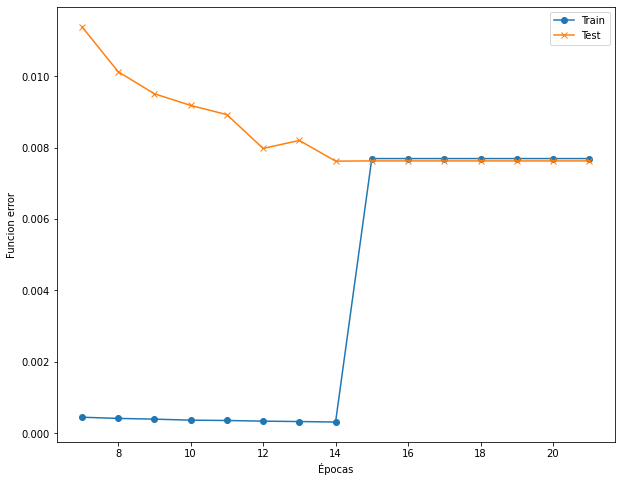

In [36]:
epochs = np.arange(7,len(train_loss_values))

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_ylabel('Funcion error')
ax.set_xlabel('Épocas')

ax.plot(epochs, np.array(train_loss_values[7:]), 'o-', label='Train')
ax.plot(epochs, np.array(test_loss_values[7:]), 'x-', label='Test')
# ax.plot(epochs, np.array(train_loss_values_old), 'o-', label='Train_old')
# ax.plot(epochs, np.array(test_loss_values_old), 'x-', label='Test_old')

ax.legend()
# ticks = [0.03, 0.04, 0.05, 0.06, 0.07]
# tickLabels = map(str, ticks)

# plt.yticks(ticks)
plt.savefig( "Train-vs-test.png")

plt.show()

Dato no relevante para presente Practico


In [ ]:
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784)
        reconstruction = model(test_examples)
        break

RuntimeError: ignored

In [ ]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
dir_name = '/content/gdrive/My Drive/Colab Notebooks/pytorch/Autoencoder_MNIST_files'
base_model_name = 'hidden{:04}_dropout{:.3f}_batch{:05}_lr{:.6f}_momentum{:.6f}'.format(
    hidden_layer_size, dropout, train_batch_size, learning_rate, momentum
)
model_name = base_model_name + '.pt'
loss_name  = base_model_name + '.txt'

print(model_name)
model_path = os.path.join(dir_name, 'models', model_name)
loss_path = os.path.join(dir_name, 'loss', loss_name)


In [ ]:
train_loss_dict = {}
test_loss_dict = {}

hidden_values = [64,128,256,512]

for hidden in hidden_values:

    inpt_file_name = 'hidden{:04}_dropout{:.3f}_batch{:05}_lr{:.6f}_momentum{:.6f}'.format(
        hidden, dropout, train_batch_size, learning_rate, momentum
    )
    train_loss, test_loss = np.loadtxt(str(hidden)).T

    train_loss_dict[hidden] = train_loss
    test_loss_dict[hidden] = test_loss

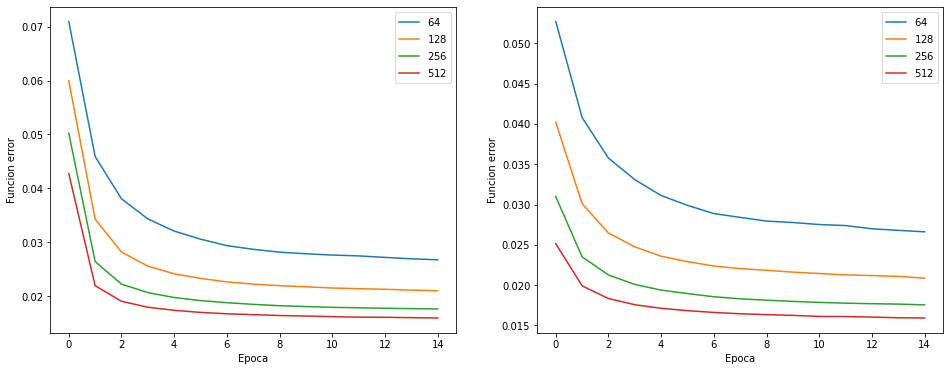

In [ ]:

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for hidden in hidden_values:
    train_loss, test_loss = train_loss_dict[hidden], test_loss_dict[hidden]
    for i, loss_values in enumerate([train_loss, test_loss]):
        ax = axes[i]
        epochs = np.arange(train_loss.shape[0])
        ax.plot(epochs, loss_values, label=r'${{{}}}$'.format(hidden))

for ax in axes:
    ax.set_ylabel('Funcion error')
    ax.set_xlabel('Epoca')
    ax.legend()

plt.show()